## EXP 1 - XGBoost

### Import các thư viện cần thiết và tải lên các file dữ liệu 

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set random seed để đảm bảo kết quả có thể tái lập
RANDOM_STATE = 42

In [3]:
# Load dữ liệu đã qua Feature Engineering
train_exp1 = pd.read_csv('../../data/exp1/train_exp1.csv')
test_exp1 = pd.read_csv('../../data/exp1/test_exp1.csv')

### Chuẩn bị features và target

In [4]:
# Lấy cột target (Class)
y_train = train_exp1['Class']

# Loại bỏ các cột không phải là feature
X_train = train_exp1.drop(['Class', 'Id', 'Artist Name', 'Track Name'], axis=1, errors='ignore')
X_test = test_exp1.drop(['Id', 'Artist Name', 'Track Name'], axis=1, errors='ignore')

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (14396, 14)
y_train shape: (14396,)
X_test shape: (3600, 14)


### Phân phối của target và thiết lập mô hình

In [5]:
# Tạo DMatrix cho XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

In [6]:
# Thiết lập tham số cho XGBoost

xgb_params = {
    'objective': 'multi:softprob',
    'num_class': len(y_train.unique()),
    'eval_metric': 'mlogloss',
    'learning_rate': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': RANDOM_STATE,
    'verbosity': 0
}

print("Tham số đã được thiết lập!")

Tham số đã được thiết lập!


### Huấn luyện mô hình

In [7]:
xgb_model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=100,
    evals=[(dtrain, 'train')],
    verbose_eval=50
)

print("Huấn luyện XGBoost hoàn tất!")

[0]	train-mlogloss:2.20345
[50]	train-mlogloss:0.97172
[99]	train-mlogloss:0.78983
Huấn luyện XGBoost hoàn tất!


### Đánh giá mô hình

In [8]:
# Dự đoán
y_train_pred_proba_xgb = xgb_model.predict(dtrain)
y_train_pred_class_xgb = np.argmax(y_train_pred_proba_xgb, axis=1)

# Tính metrics
train_accuracy_xgb = accuracy_score(y_train, y_train_pred_class_xgb)
train_f1_xgb = f1_score(y_train, y_train_pred_class_xgb, average='weighted')
train_log_loss_xgb = log_loss(y_train, y_train_pred_proba_xgb)

# Cross-validation với sklearn interface
xgb_sklearn = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=len(y_train.unique()),
    learning_rate=0.1,
    n_estimators=100,
    max_depth=6,
    random_state=RANDOM_STATE,
    verbosity=0
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_f1_scores_xgb = cross_val_score(xgb_sklearn, X_train, y_train, cv=cv, scoring='f1_weighted', n_jobs=-1)
cv_accuracy_scores_xgb = cross_val_score(xgb_sklearn, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)

print(f"Độ chính xác tập train: {train_accuracy_xgb:.4f}")
print(f"F1-Score tập train: {train_f1_xgb:.4f}")
print(f"Log Loss tập train: {train_log_loss_xgb:.4f}")
print(f"F1-Score CV: {cv_f1_scores_xgb.mean():.4f} (±{cv_f1_scores_xgb.std() * 2:.4f})")
print(f"Accuracy CV: {cv_accuracy_scores_xgb.mean():.4f} (±{cv_accuracy_scores_xgb.std() * 2:.4f})")

Độ chính xác tập train: 0.7210
F1-Score tập train: 0.7024
Log Loss tập train: 0.7898
F1-Score CV: 0.5182 (±0.0149)
Accuracy CV: 0.5399 (±0.0143)


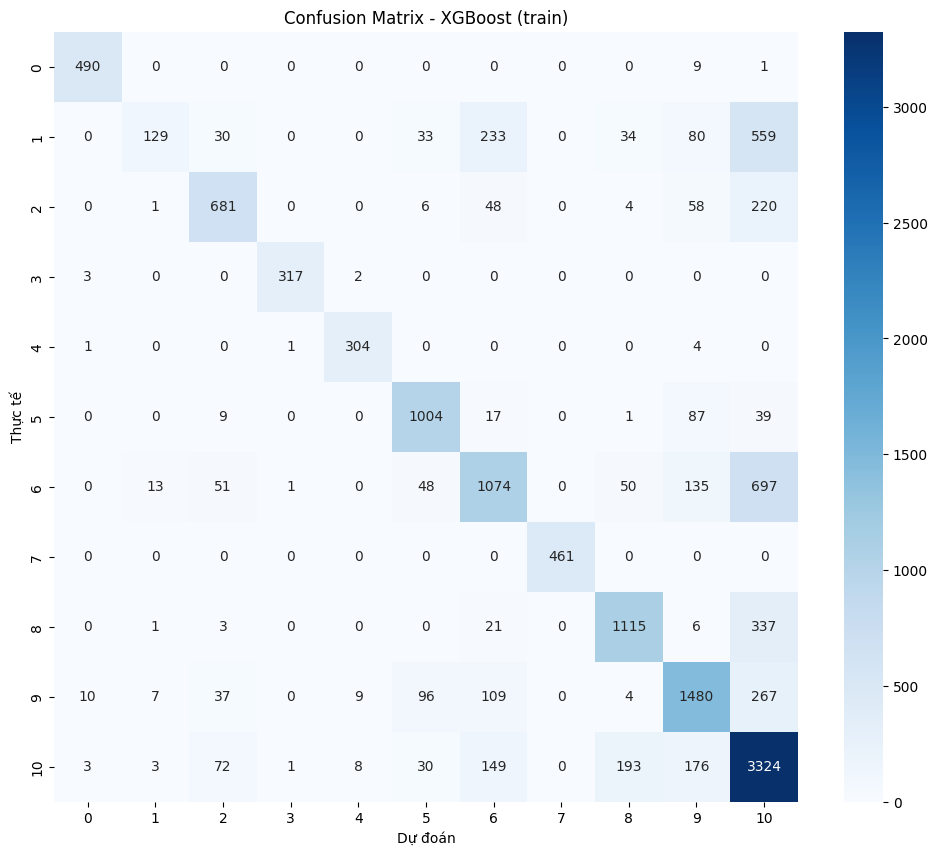

In [9]:
# Confusion Matrix (trên tập train)
cm_xgb = confusion_matrix(y_train, y_train_pred_class_xgb)

plt.figure(figsize=(12, 10))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - XGBoost (train)')
plt.ylabel('Thực tế')
plt.xlabel('Dự đoán')
plt.show()

### Dự đoán trên tập test


In [13]:
test_predictions_proba = xgb_model.predict(dtest)
test_predictions = np.argmax(test_predictions_proba, axis=1)

print(f"Số lượng dự đoán: {len(test_predictions)}")
print("Phân phối dự đoán:")
print(pd.Series(test_predictions).value_counts().sort_index())

Số lượng dự đoán: 3600
Phân phối dự đoán:
0      156
1       28
2      265
3       74
4       77
5      277
6      425
7      109
8      320
9      408
10    1461
Name: count, dtype: int64


In [14]:
# Tạo submission file
submission_xgb = pd.DataFrame({
    'Id': test_exp1['Id'],
    'Class': test_predictions
})

# Lưu file submission
submission_file_path_xgb = 'results/XGB_submission.csv'
submission_xgb.to_csv(submission_file_path_xgb, index=False)
print(f"File submission đã được lưu tại: {submission_file_path_xgb}")
print(f"Kích thước file submission: {submission_xgb.shape}")

File submission đã được lưu tại: results/XGB_submission.csv
Kích thước file submission: (3600, 2)


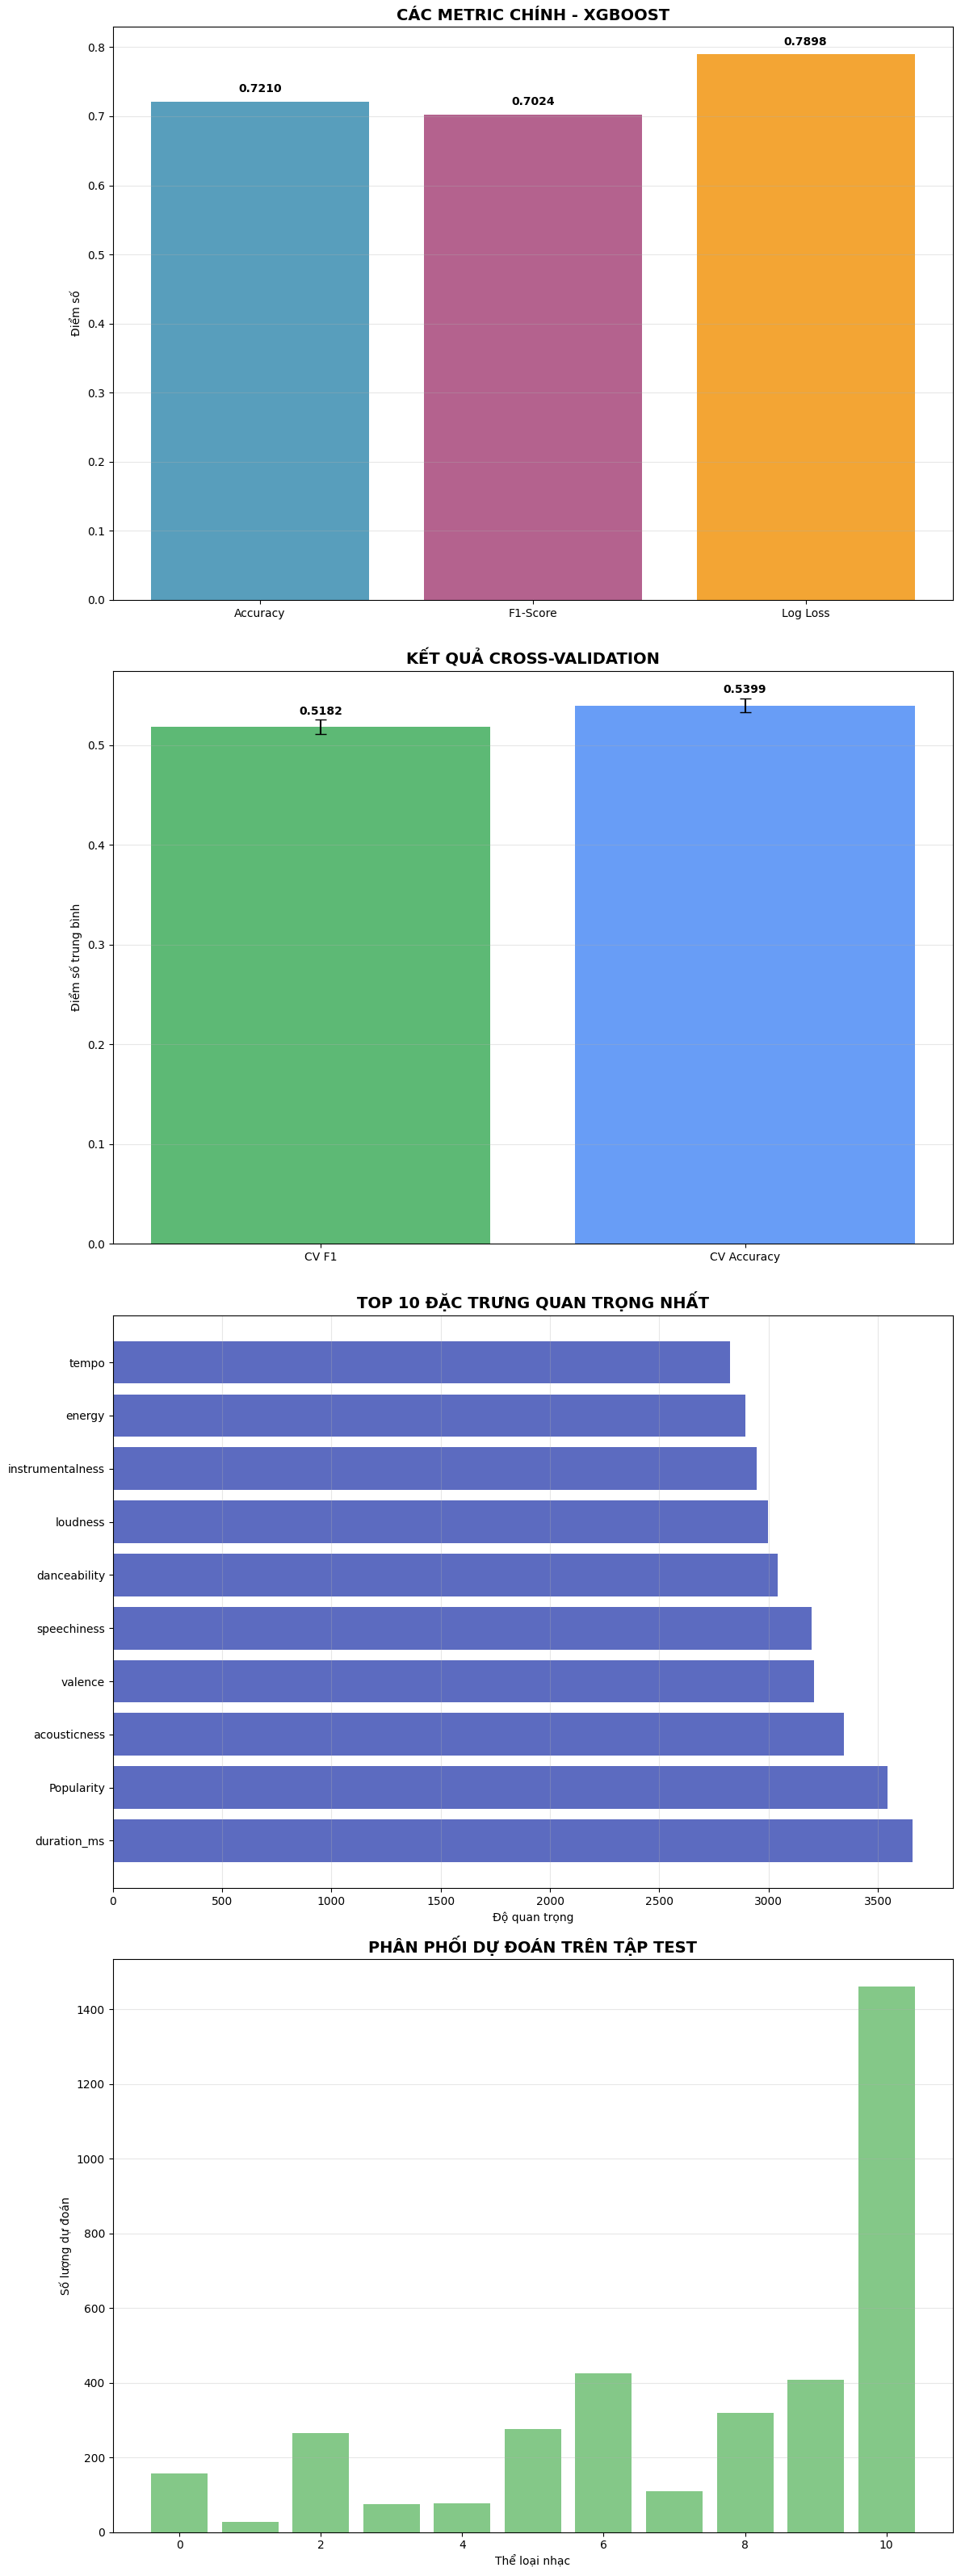

In [15]:
# Biểu đồ XGBoost
fig, axes = plt.subplots(4, 1, figsize=(12, 32))

# 1. Biểu đồ metrics chính
metrics_xgb = ['Accuracy', 'F1-Score', 'Log Loss']
values_xgb = [train_accuracy_xgb, train_f1_xgb, train_log_loss_xgb]
colors_xgb = ['#2E86AB', '#A23B72', '#F18F01']

bars_xgb = axes[0].bar(metrics_xgb, values_xgb, color=colors_xgb, alpha=0.8)
axes[0].set_title('CÁC METRIC CHÍNH - XGBOOST', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Điểm số')
axes[0].grid(axis='y', alpha=0.3)

for bar, value in zip(bars_xgb, values_xgb):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

# 2. Biểu đồ cross-validation
cv_metrics_xgb = ['CV F1', 'CV Accuracy']
cv_means_xgb = [cv_f1_scores_xgb.mean(), cv_accuracy_scores_xgb.mean()]
cv_stds_xgb = [cv_f1_scores_xgb.std(), cv_accuracy_scores_xgb.std()]

bars_cv_xgb = axes[1].bar(cv_metrics_xgb, cv_means_xgb, yerr=cv_stds_xgb, capsize=5, 
                         color=['#34A853', '#4285F4'], alpha=0.8)
axes[1].set_title('KẾT QUẢ CROSS-VALIDATION', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Điểm số trung bình')
axes[1].grid(axis='y', alpha=0.3)

for bar, value in zip(bars_cv_xgb, cv_means_xgb):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

# 3. Biểu đồ feature importance 
feature_scores = xgb_model.get_score(importance_type='weight')

# Tạo DataFrame đúng cách
feature_importance_list = []
for feature_name in X_train.columns:
    importance_score = feature_scores.get(feature_name, 0)
    feature_importance_list.append({
        'feature': feature_name,
        'importance': importance_score
    })

feature_importance_xgb = pd.DataFrame(feature_importance_list)
feature_importance_xgb = feature_importance_xgb.sort_values('importance', ascending=False).head(10)

axes[2].barh(range(len(feature_importance_xgb)), feature_importance_xgb['importance'], color='#5C6BC0')
axes[2].set_yticks(range(len(feature_importance_xgb)))
axes[2].set_yticklabels(feature_importance_xgb['feature'])
axes[2].set_title('TOP 10 ĐẶC TRƯNG QUAN TRỌNG NHẤT', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Độ quan trọng')
axes[2].grid(axis='x', alpha=0.3)

# 4. Biểu đồ phân phối dự đoán
pred_distribution_xgb = pd.Series(test_predictions).value_counts().sort_index()
axes[3].bar(pred_distribution_xgb.index, pred_distribution_xgb.values, color='#66BB6A', alpha=0.8)
axes[3].set_title('PHÂN PHỐI DỰ ĐOÁN TRÊN TẬP TEST', fontsize=14, fontweight='bold')
axes[3].set_xlabel('Thể loại nhạc')
axes[3].set_ylabel('Số lượng dự đoán')
axes[3].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()